In [52]:
import re
import polars
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas
import math
import itertools
import pandas as pd
from scipy.stats import mannwhitneyu

In [53]:
closest_square = lambda x : math.ceil(math.sqrt(x))

In [54]:
closest_square(5)

3

In [55]:

file = "../experimentlog.txt"

# Regex with named groups for elapsed time and records
pattern = (
    r'^(?P<TimeStamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| '
    r'(?P<LogType>\w+) \| '
    r'(?P<FuncRaw>[\w_]+)\s*\| '
    r'(?P<Transport>\w+)\s*\| '
    r'(?P<Status>\w+)\s*\| '
    r'\s*(?P<Latency>[\d.]+)s \| '
    r'\s*records=(?P<records>\d+)'
)
regex = re.compile(pattern)

data = []

with open(file, "r") as f:
    for line in f:
        line = line.strip()
        match = regex.search(line)
        if match:
            row = match.groupdict()
            # Convert types
            row["Latency"] = float(row["Latency"])
            row["records"] = int(row["records"])
            data.append(row)

df = polars.DataFrame(data)
df = df.with_columns(
    (polars.col("records") / polars.col("Latency")).alias("records_per_latency")
)
del data

grouped = (
    df.group_by(["records", "Transport"])
      .agg([
          polars.col("Latency").sum().alias("Latency_sum"),
          polars.col("Latency").mean().alias("Latency_mean"),
          polars.col("Latency").min().alias("Latency_min"),
          polars.col("Latency").max().alias("Latency_max"),
          polars.col("Latency").std().alias("Latency_std"),
          polars.count("Latency").alias("count"),
          polars.col("records_per_latency").mean().alias("rps_mean"),
          polars.col("records_per_latency").min().alias("rps_min"),
          polars.col("records_per_latency").max().alias("rps_max"),
          polars.col("records_per_latency").median().alias("rps_median"),
          polars.col("records_per_latency").std().alias("rps_std"),
          polars.col("records_per_latency").var().alias("rps_var"),
      ])
)
grouped = grouped.sort('records', descending=True)
grouped.show(100)

records,Transport,Latency_sum,Latency_mean,Latency_min,Latency_max,Latency_std,count,rps_mean,rps_min,rps_max,rps_median,rps_std,rps_var
i64,str,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64
1000,"""cnpnp""",0.938488,0.00408,0.00329,0.015726,0.001281,230,253647.192508,63588.960956,303951.367781,255983.65479,30348.5128,9.2103e8
1000,"""http""",0.881104,0.003831,0.003027,0.013197,0.001524,230,276979.877225,75774.797302,330360.092501,282725.496164,43093.504456,1.8571e9
1000,"""arrow_grpc""",0.546098,0.002374,0.001904,0.011092,0.001024,230,442879.212741,90155.066715,525210.084034,437445.654171,60477.079401,3.6575e9
1000,"""grpc""",0.540547,0.00235,0.001873,0.011318,0.001028,230,447691.228693,88354.833009,533902.829685,442477.876106,61471.700565,3.7788e9
1000,"""arrow""",1.211026,0.005265,0.004566,0.01416,0.001041,230,193430.792172,70621.468927,219010.074463,193967.623829,19329.682526,3.7364e8
1000,"""cnpnp_grpc""",0.538875,0.002343,0.001899,0.010976,0.001006,230,449177.366734,91107.87172,526592.943655,445732.314252,62966.555675,3.9648e9
100,"""cnpnp_grpc""",0.150914,0.000656,0.000577,0.000889,0.000053,230,153342.926003,112485.939258,173310.225303,154559.50541,11657.307052,1.3589e8
100,"""http""",0.353038,0.001535,0.001343,0.002727,0.000157,230,65690.253831,36670.3337,74460.163812,66578.014184,5489.531431,3.0135e7
100,"""arrow""",0.411487,0.001789,0.00159,0.002491,0.000145,230,56235.517339,40144.520273,62893.081761,56753.70727,4237.756966,1.7959e7


In [56]:
import numpy as np

# Convert Polars → Python groups
groups = {}
for row in df.iter_rows(named=True):
    key = (row["Transport"], row["records"])
    groups.setdefault(key, []).append(row["Latency"])


In [57]:
def convergence_point(samples, threshold=0.001):
    samples = np.array(samples)
    n = len(samples)

    mean = 0.0
    M2 = 0.0

    means = []
    vars_ = []

    for i, x in enumerate(samples, start=1):
        delta = x - mean
        mean += delta / i
        delta2 = x - mean
        M2 += delta * delta2

        if i > 1:
            variance = M2 / (i - 1)
        else:
            variance = np.nan

        means.append(mean)
        vars_.append(variance)

    means = np.array(means)
    std = np.sqrt(vars_)
    se = std / np.sqrt(np.arange(1, n + 1))
    ci95 = 1.96 * se

    rel_error = ci95 / means[-1]

    idx = np.where(rel_error < threshold)[0]
    return idx[0] + 1 if len(idx) else n


In [58]:
results = []

for (transport, records), latencies in groups.items():
    n01 = convergence_point(latencies, threshold=0.001)   # 0.1%
    n025 = convergence_point(latencies, threshold=0.0025) # 0.25%

    results.append({
        "Transport": transport,
        "records": records,
        "N_0.1pct": n01,
        "N_0.25pct": n025,
        "total": len(latencies)
    })


In [59]:
import pandas as pd

conv_df = pd.DataFrame(results)

worst_01 = conv_df["N_0.1pct"].max()
worst_025 = conv_df["N_0.25pct"].max()

conv_df.sort_values("N_0.1pct", ascending=False).head(10), worst_01, worst_025


(    Transport  records  N_0.1pct  N_0.25pct  total
 0        http       10       230        230    230
 1        grpc       10       230        230    230
 2       cnpnp       10       230        230    230
 3  cnpnp_grpc       10       230        230    230
 4       arrow       10       230        230    230
 5  arrow_grpc       10       230        230    230
 6        http      100       230        230    230
 7        grpc      100       230        230    230
 8       cnpnp      100       230        230    230
 9  cnpnp_grpc      100       230        230    230,
 np.int64(230),
 np.int64(230))

In [75]:
import plotly.graph_objects as go
import numpy as np

# Choose batch sizes
batch_sizes = [10, 100, 1000]  # adjust as needed
protocols = df["Transport"].unique().to_list()

fig = go.Figure()

for BATCH in batch_sizes:
    for proto in protocols:
        # Get latency array
        lat = df.filter((polars.col("records") == BATCH) &
                        (polars.col("Transport") == proto))["Latency"].to_numpy().flatten()

        # Welford running mean & variance
        n = len(lat)
        mean = 0.0
        M2 = 0.0
        means = []
        vars_ = []

        for i, x in enumerate(lat, start=1):
            delta = x - mean
            mean += delta / i
            delta2 = x - mean
            M2 += delta * delta2
            if i > 1:
                variance = M2 / (i - 1)
            else:
                variance = 0
            means.append(mean)
            vars_.append(variance)

        means = np.array(means)
        std = np.sqrt(np.array(vars_))
        se = std / np.sqrt(np.arange(1, n + 1))
        ci95 = 1.96 * se

        x = np.arange(1, n + 1)
        # Plot running mean
        fig.add_trace(go.Scatter(
            x=x,
            y=means,
            mode='lines',
            name=f"{proto} mean (batch {BATCH})"
        ))
        # Plot shaded CI
        fig.add_trace(go.Scatter(
            x=np.concatenate([x, x[::-1]]),
            y=np.concatenate([means - ci95, (means + ci95)[::-1]]),
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False,
        ))

    # Add vertical line for convergence point
    fig.add_trace(go.Scatter(
        x=[100, 100],
        y=[min(lat), max(lat)],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name=f"Convergence (100 trials) batch {BATCH}"
    ))

fig.update_layout(
    title="Convergence of Running Mean Latency Across Protocols",
    xaxis_title="Number of trials",
    yaxis_title="Latency (s)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [61]:
df_pandas = df.to_pandas()

alpha = 0.01

summary_rows = []

for r in df_pandas['records'].unique():
    df_r = df_pandas[df_pandas['records'] == r]
    
    stats = (
        df_r.groupby('Transport')['Latency']
        .agg(['mean', 'std'])
        .reset_index()
    )
    
    model = ols('Latency ~ C(Transport)', data=df_r).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc['C(Transport)', 'PR(>F)']
    
    stats['records'] = r
    stats['anova_p'] = p_value
    
    # 🔹 significance check
    stats['significant_0_01'] = p_value < alpha
    
    summary_rows.append(stats)

summary_df = pandas.concat(summary_rows, ignore_index=True)

print(summary_df)


     Transport      mean       std  records        anova_p  significant_0_01
0        arrow  0.002075  0.008824       10   2.026530e-07              True
1   arrow_grpc  0.000484  0.000043       10   2.026530e-07              True
2        cnpnp  0.001375  0.000103       10   2.026530e-07              True
3   cnpnp_grpc  0.000463  0.000042       10   2.026530e-07              True
4         grpc  0.000476  0.000082       10   2.026530e-07              True
5         http  0.001370  0.000284       10   2.026530e-07              True
6        arrow  0.001789  0.000145      100   0.000000e+00              True
7   arrow_grpc  0.000651  0.000046      100   0.000000e+00              True
8        cnpnp  0.001557  0.000151      100   0.000000e+00              True
9   cnpnp_grpc  0.000656  0.000053      100   0.000000e+00              True
10        grpc  0.000656  0.000045      100   0.000000e+00              True
11        http  0.001535  0.000157      100   0.000000e+00              True

In [62]:
df_pd = df.to_pandas()
alpha = 0.01

results = []

for record, df_r in df_pd.groupby("records"):
    transports = df_r["Transport"].unique()
    
    # non-redundant pairs
    for t1, t2 in itertools.combinations(transports, 2):
        x = df_r[df_r["Transport"] == t1]["Latency"]
        y = df_r[df_r["Transport"] == t2]["Latency"]

        # Mann–Whitney U (two-sided is standard)
        stat, p = mannwhitneyu(x, y, alternative="two-sided")

        results.append({
            "records": record,
            "Transport_A": t1,
            "Transport_B": t2,
            "U_stat": stat,
            "p_value": p,
            "significant_0_01": p < alpha
        })

mw_df = pd.DataFrame(results).sort_values(
    ["records", "p_value"]
)

mw_df

,records,Transport_A,Transport_B,U_stat,p_value,significant_0_01
12,10,cnpnp_grpc,arrow,0.0,7.585370e-77,True
14,10,arrow,arrow_grpc,52900.0,7.585370e-77,True
9,10,cnpnp,cnpnp_grpc,52900.0,7.587469e-77,True
11,10,cnpnp,arrow_grpc,52900.0,7.587469e-77,True
2,10,http,cnpnp_grpc,52900.0,7.588842e-77,True
4,10,http,arrow_grpc,52900.0,7.588842e-77,True
7,10,grpc,arrow,171.5,7.065583e-76,True
0,10,http,grpc,52679.0,1.342400e-75,True
5,10,grpc,cnpnp,223.0,1.377361e-75,True
3,10,http,arrow,9487.5,1.204488e-32,True


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm


In [64]:
def plot_mw_latency_triangle_ax(ax, mw_df, record, alpha=0.01):
    """
    Plot a lower-triangular heatmap of MW U test significance for Latency.
    mw_df must have columns: records, Transport_A, Transport_B, p_value
    """
    df_r = mw_df[mw_df["records"] == record]

    if df_r.empty:
        ax.set_title(f"records={record}\n(no data)")
        ax.axis("off")
        return

    # Get unique transports
    transports = sorted(set(df_r["Transport_A"]).union(df_r["Transport_B"]))
    if len(transports) < 2:
        ax.set_title(f"records={record}\n(not enough transports)")
        ax.axis("off")
        return

    # Create a matrix of significance (True/False)
    mat = pd.DataFrame(
        np.ones((len(transports), len(transports)), dtype=bool),  # default True = significant
        index=transports,
        columns=transports
    )

    # Fill matrix: True if p < alpha, False otherwise
    for _, r in df_r.iterrows():
        sig = r["p_value"] < alpha
        mat.loc[r["Transport_A"], r["Transport_B"]] = sig
        mat.loc[r["Transport_B"], r["Transport_A"]] = sig

    # Mask upper triangle
    mask = np.triu(np.ones_like(mat, dtype=bool))

    # Use red for significant, blue for not
    cmap = sns.color_palette(["#1f77b4", "#d62728"])  # blue = not significant, red = significant

    sns.heatmap(
        mat.astype(int),        # seaborn needs numeric data
        mask=mask,
        ax=ax,
        cmap=cmap,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cbar=False
    )

    ax.set_title(f"records = {record}")
    ax.set_xlabel("Transport")
    ax.set_ylabel("Transport")

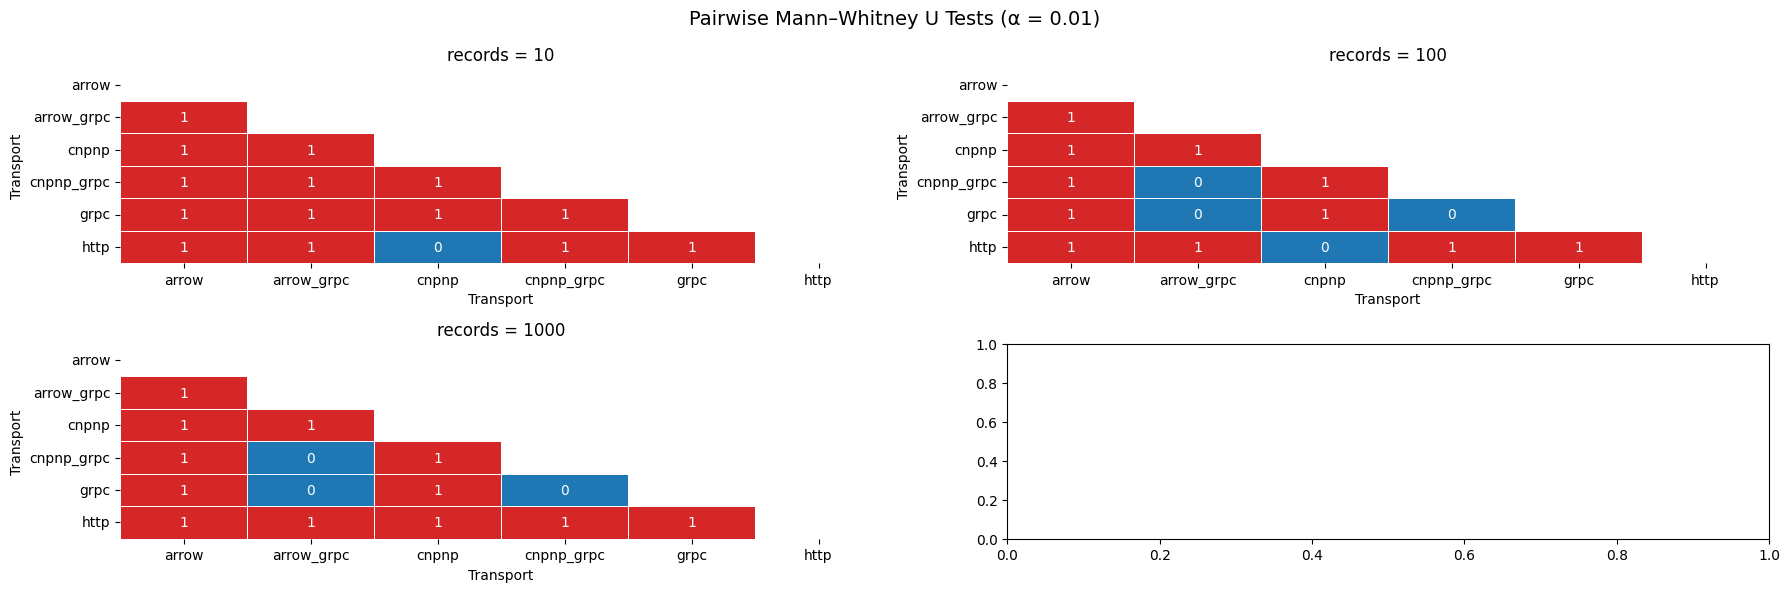

In [65]:
import matplotlib.pyplot as plt

records_to_plot = summary_df['records'].unique()
plots = closest_square(len(records_to_plot))

fig, axes = plt.subplots(
    plots, plots,
    figsize=(18, 6),
    squeeze=False
)
axes_flat = axes.flatten()

for ax, rec in zip(axes_flat, records_to_plot):
    plot_mw_latency_triangle_ax(ax, mw_df, rec, alpha=0.01)


from matplotlib.cm import ScalarMappable

sm = ScalarMappable(
    cmap="viridis_r",
    norm=LogNorm(vmin=1e-80, vmax=0.01)
)
sm.set_array([])


fig.suptitle(
    "Pairwise Mann–Whitney U Tests (α = 0.01)",
    fontsize=14
)
plt.tight_layout()
plt.show()



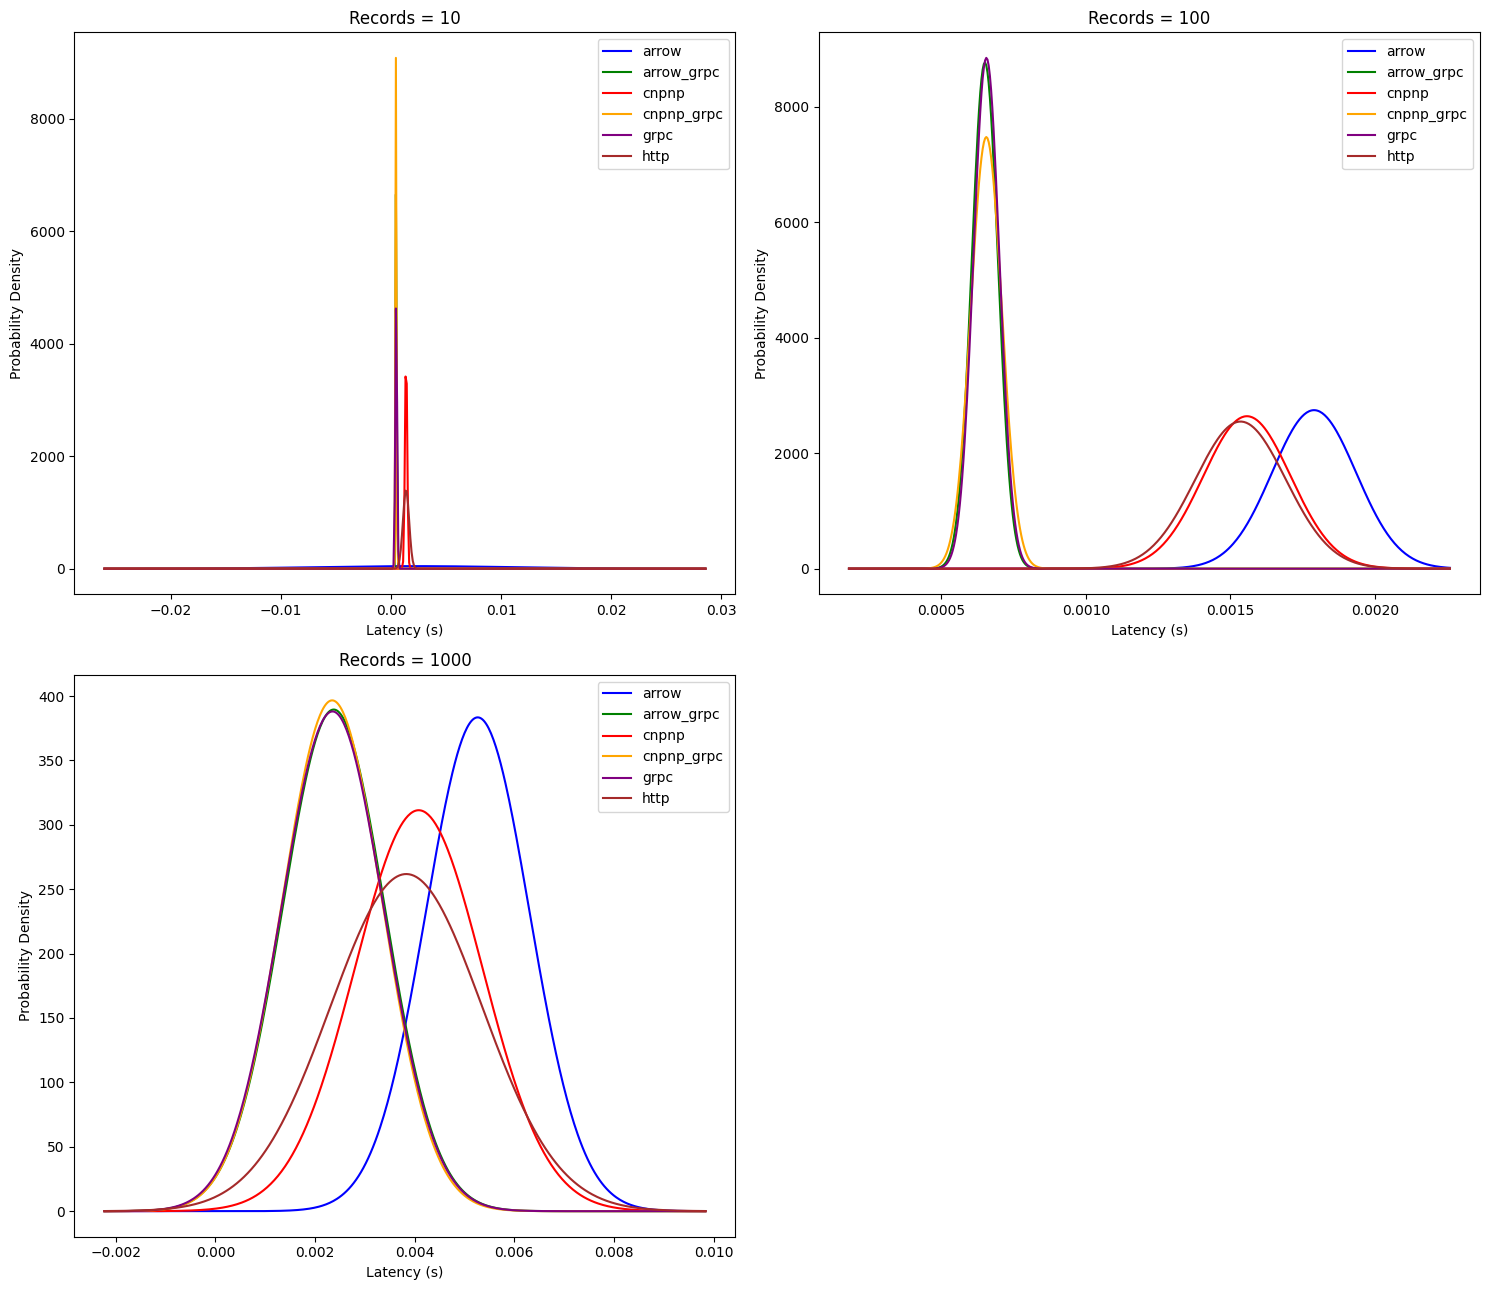

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd

# Assuming your summary_df from earlier
# Columns: Transport, mean, std, records, anova_p

records_groups = summary_df['records'].unique()
transports = summary_df['Transport'].unique()

plots_per_row = closest_square(len(records_groups))

fig, axes = plt.subplots(plots_per_row, plots_per_row, figsize=(15, 13))
axes = axes.flatten()

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

for i, r in enumerate(records_groups):
    ax = axes[i]
    df_r = summary_df[summary_df['records'] == r]
    
    x_min = df_r['mean'].min() - 3*df_r['std'].max()
    x_max = df_r['mean'].max() + 3*df_r['std'].max()
    x = np.linspace(x_min, x_max, 500)
    
    for j, transport in enumerate(transports):
        row = df_r[df_r['Transport'] == transport].iloc[0]
        y = norm.pdf(x, loc=row['mean'], scale=row['std'])
        ax.plot(x, y, label=transport, color=colors[j])
    
    ax.set_title(f"Records = {r}")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Hide unused axes if any
for k in range(i+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()


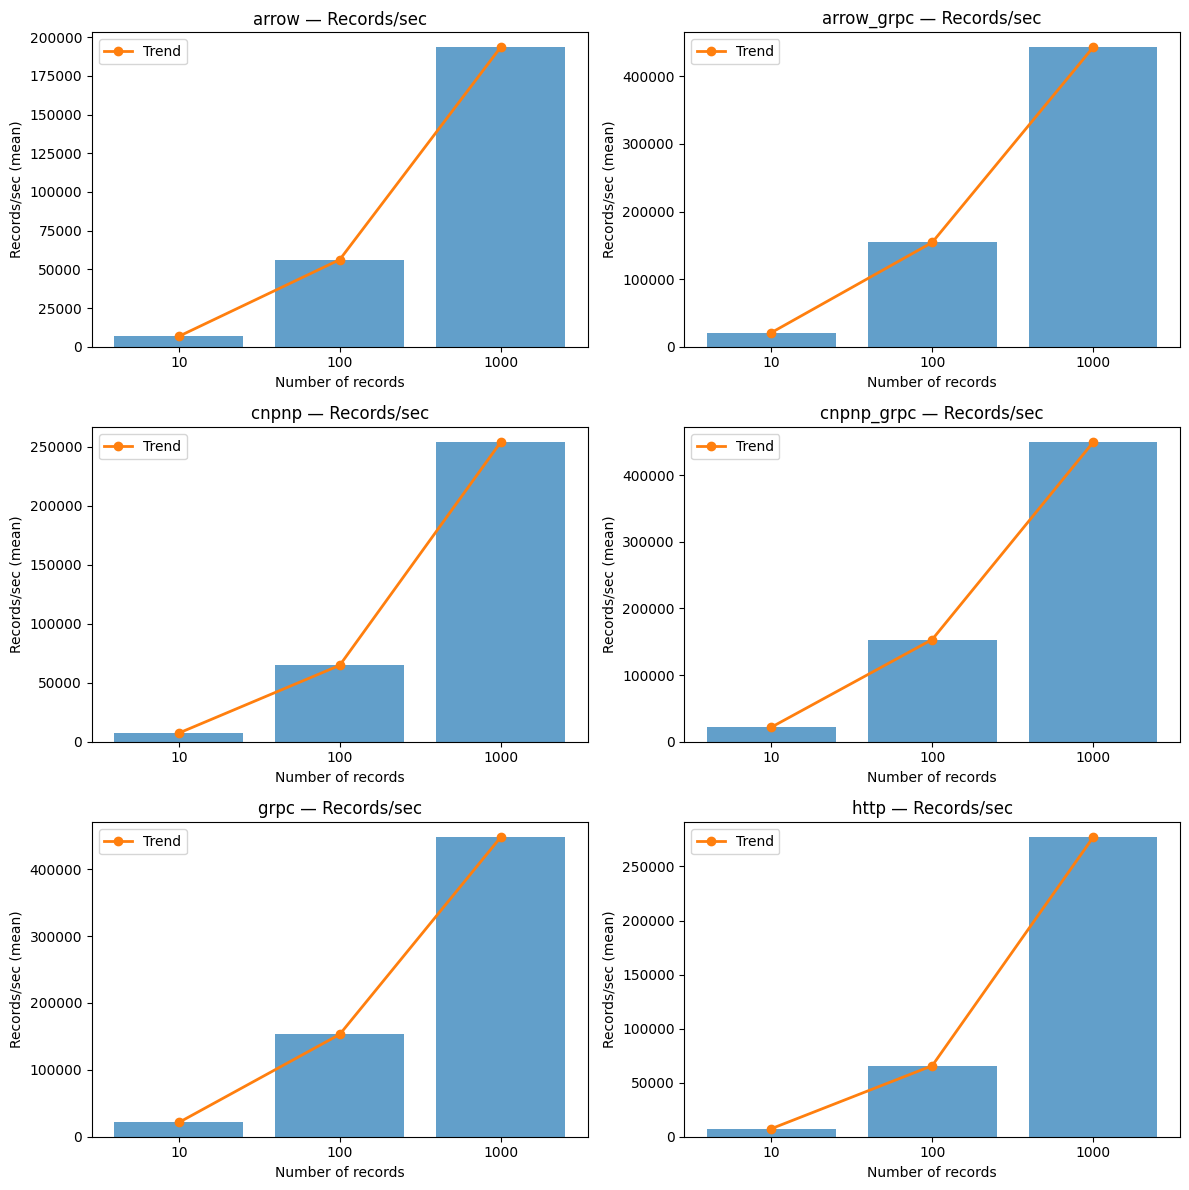

In [67]:
# Unique transports
transports_unique = sorted(list(set(grouped['Transport'].to_list())))

# Subplots
n_transports = len(transports_unique)
cols = 2
rows = (n_transports + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)
axes_flat = axes.flatten()

for ax, transport in zip(axes_flat, transports_unique):
    # Filter grouped dataframe for this transport
    df_t = grouped.filter(polars.col("Transport") == transport).sort("records")

    # Convert records to string for categorical x-axis
    x_labels = [str(r) for r in df_t["records"].to_list()]
    y_values = df_t["rps_mean"].to_list()

    # Bar plot
    ax.bar(x_labels, y_values, color="#1f77b4", alpha=0.7)

    # Line plot on same x-axis
    ax.plot(x_labels, y_values, color="#ff7f0e", marker="o", linewidth=2, label="Trend")

    ax.set_title(f"{transport} — Records/sec")
    ax.set_xlabel("Number of records")
    ax.set_ylabel("Records/sec (mean)")
    ax.legend()

# Hide unused axes
for ax in axes_flat[len(transports_unique):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

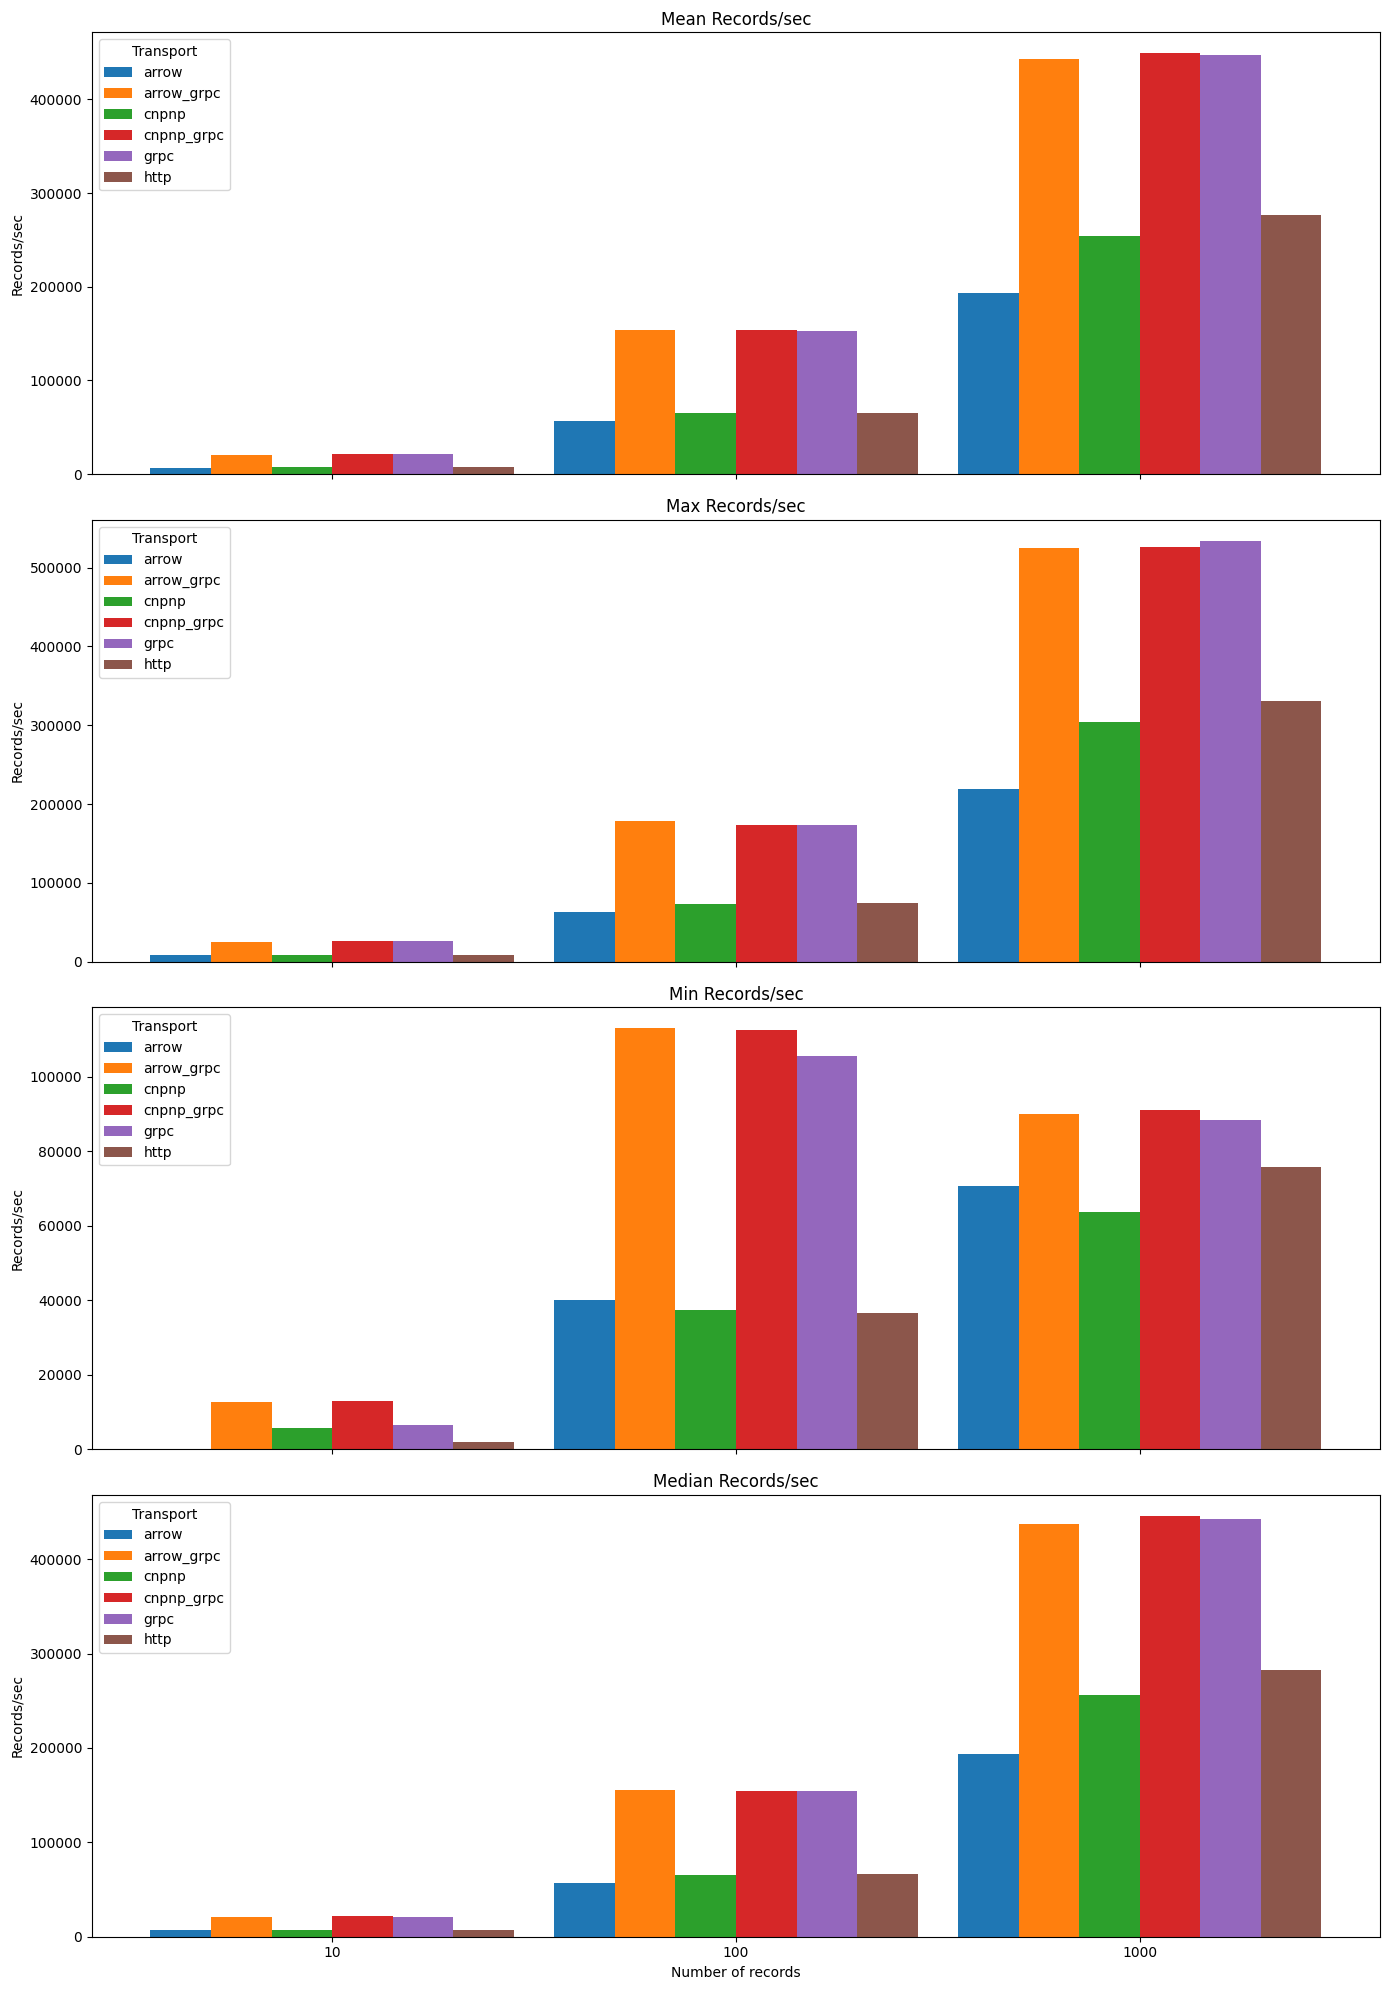

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Unique records and transports
records_unique = sorted(list(set(grouped['records'].to_list())))
transports_unique = sorted(list(set(grouped['Transport'].to_list())))

# Set bar width and positions
x = np.arange(len(records_unique))
width = 0.15
n_transports = len(transports_unique)

# Metrics to plot
metrics = ["rps_mean", "rps_max", "rps_min", "rps_median"]
titles = ["Mean Records/sec", "Max Records/sec", "Min Records/sec", "Median Records/sec"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 5*len(metrics)), sharex=True)

for ax, metric, title in zip(axes, metrics, titles):
    for i, transport in enumerate(transports_unique):
        # Filter grouped dataframe for this transport
        df_t = grouped.filter(pl.col("Transport") == transport).sort("records")
        y = df_t[metric].to_list()
        
        # Bar positions
        ax.bar(x + i*width, y, width=width, label=transport)
    
    ax.set_ylabel("Records/sec")
    ax.set_title(title)
    ax.legend(title="Transport")

# Shared x-axis labels
axes[-1].set_xticks(x + width*(n_transports-1)/2)
axes[-1].set_xticklabels([str(r) for r in records_unique])
axes[-1].set_xlabel("Number of records")

plt.tight_layout()
plt.show()


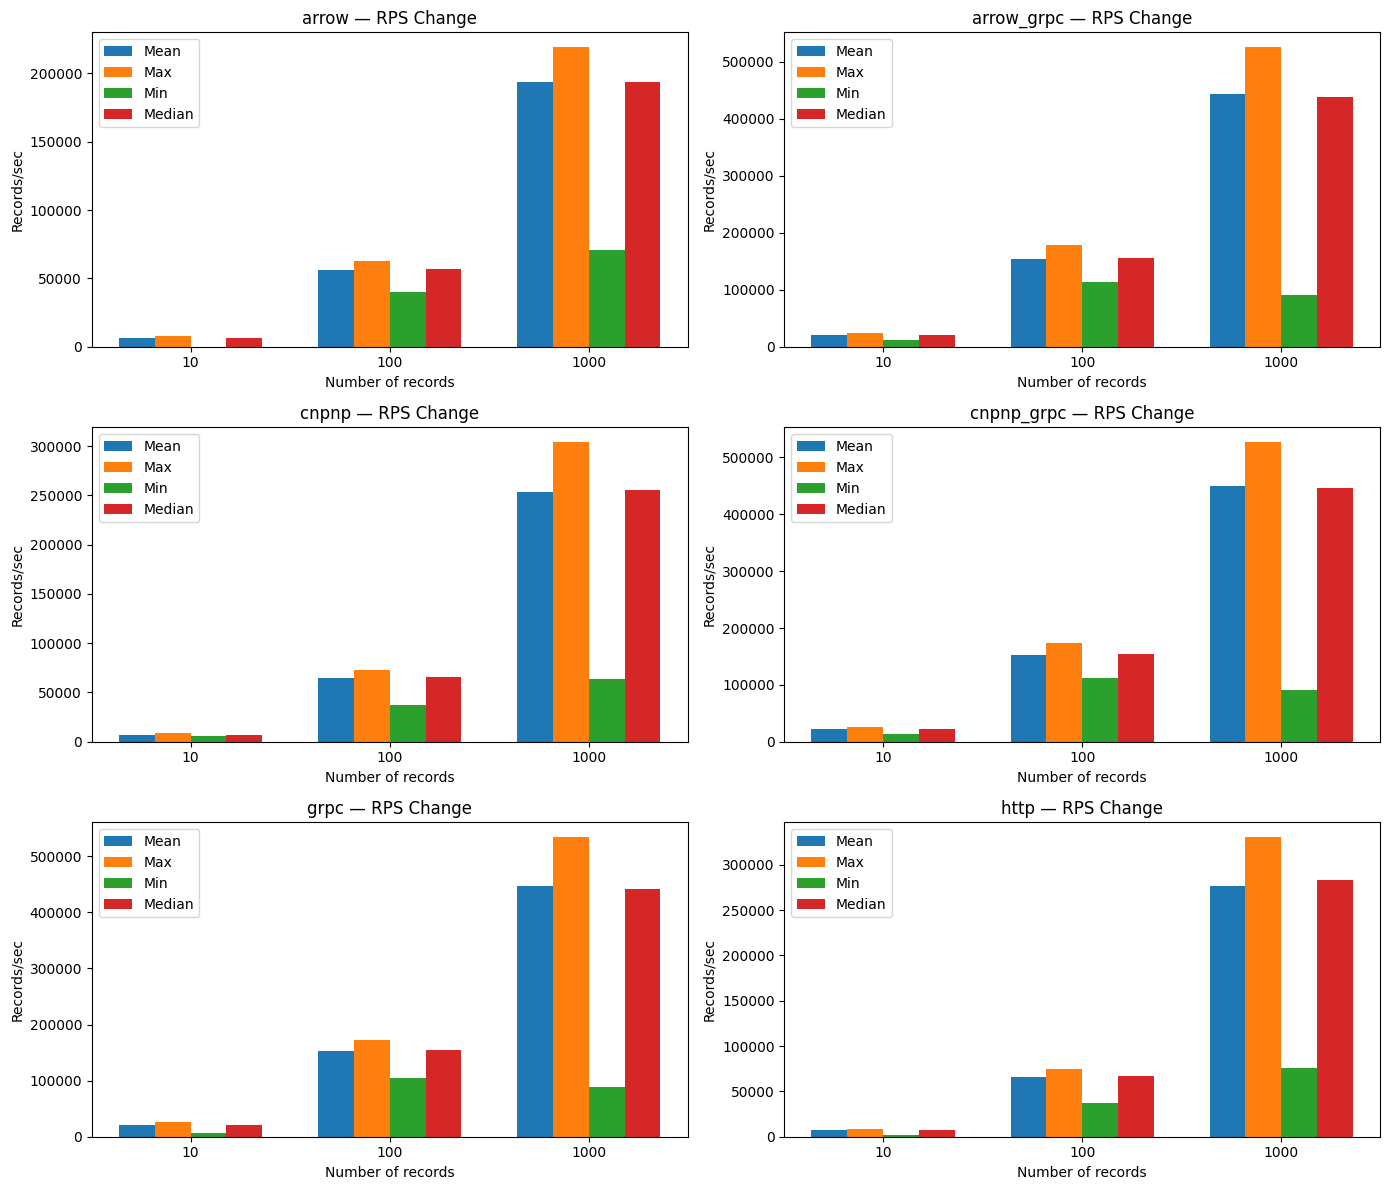

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Unique values
records_unique = sorted(grouped["records"].unique().to_list())
transports_unique = sorted(grouped["Transport"].unique().to_list())

metrics = ["rps_mean", "rps_max", "rps_min", "rps_median"]
metric_labels = ["Mean", "Max", "Min", "Median"]

# Layout
n_transports = len(transports_unique)
cols = 2
rows = (n_transports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), squeeze=False)
axes_flat = axes.flatten()

# Bar positions
x = np.arange(len(records_unique))
width = 0.18

for ax, transport in zip(axes_flat, transports_unique):
    df_t = (
        grouped
        .filter(pl.col("Transport") == transport)
        .sort("records")
    )

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        y = df_t[metric].to_list()
        ax.bar(x + i * width, y, width=width, label=label)

    ax.set_title(f"{transport} — RPS Change")
    ax.set_ylabel("Records/sec")
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels([str(r) for r in records_unique])
    ax.set_xlabel("Number of records")
    ax.legend()

# Hide unused axes
for ax in axes_flat[len(transports_unique):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


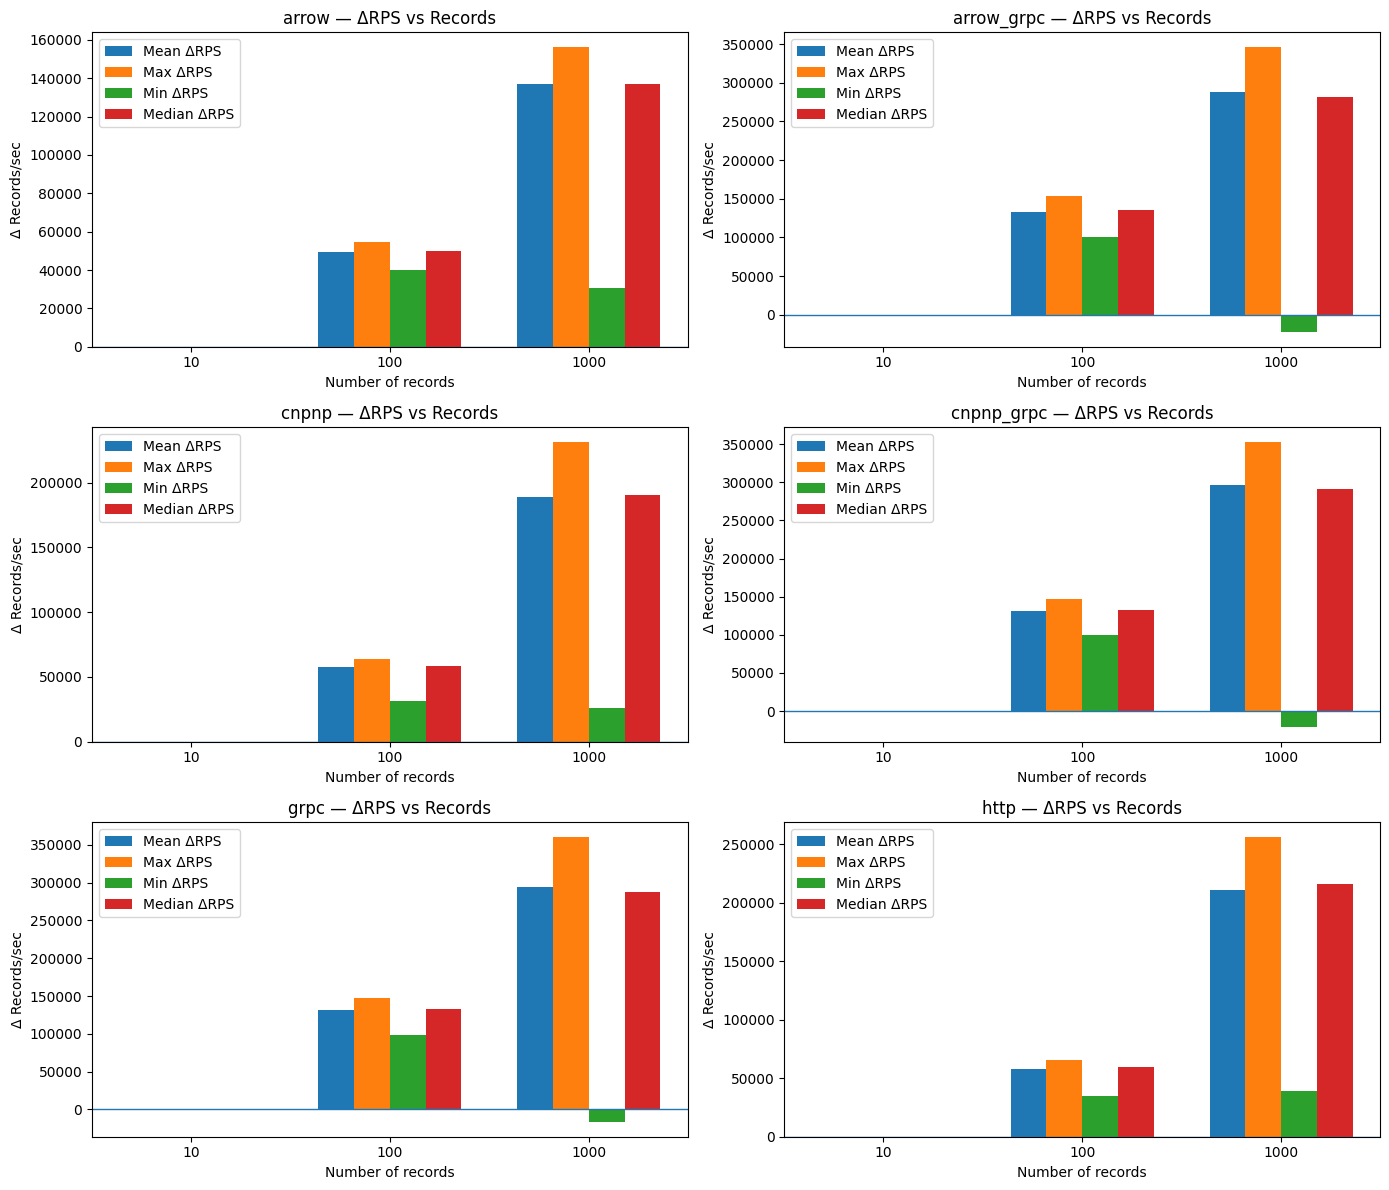

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Unique values
records_unique = sorted(grouped["records"].unique().to_list())
transports_unique = sorted(grouped["Transport"].unique().to_list())

metrics = ["rps_mean", "rps_max", "rps_min", "rps_median"]
metric_labels = ["Mean ΔRPS", "Max ΔRPS", "Min ΔRPS", "Median ΔRPS"]

# Layout
n_transports = len(transports_unique)
cols = 2
rows = (n_transports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), squeeze=False)
axes_flat = axes.flatten()

# Bar setup
x = np.arange(len(records_unique))
width = 0.18

for ax, transport in zip(axes_flat, transports_unique):
    df_t = (
        grouped
        .filter(pl.col("Transport") == transport)
        .sort("records")
    )

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = df_t[metric].to_numpy()
        delta = np.diff(values, prepend=values[0])  # ΔRPS
        ax.bar(x + i * width, delta, width=width, label=label)

    ax.axhline(0, linewidth=1)
    ax.set_title(f"{transport} — ΔRPS vs Records")
    ax.set_ylabel("Δ Records/sec")
    ax.set_xticks(x + width * (len(metrics) - 1) / 2)
    ax.set_xticklabels([str(r) for r in records_unique])
    ax.set_xlabel("Number of records")
    ax.legend()

# Hide unused axes
for ax in axes_flat[len(transports_unique):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


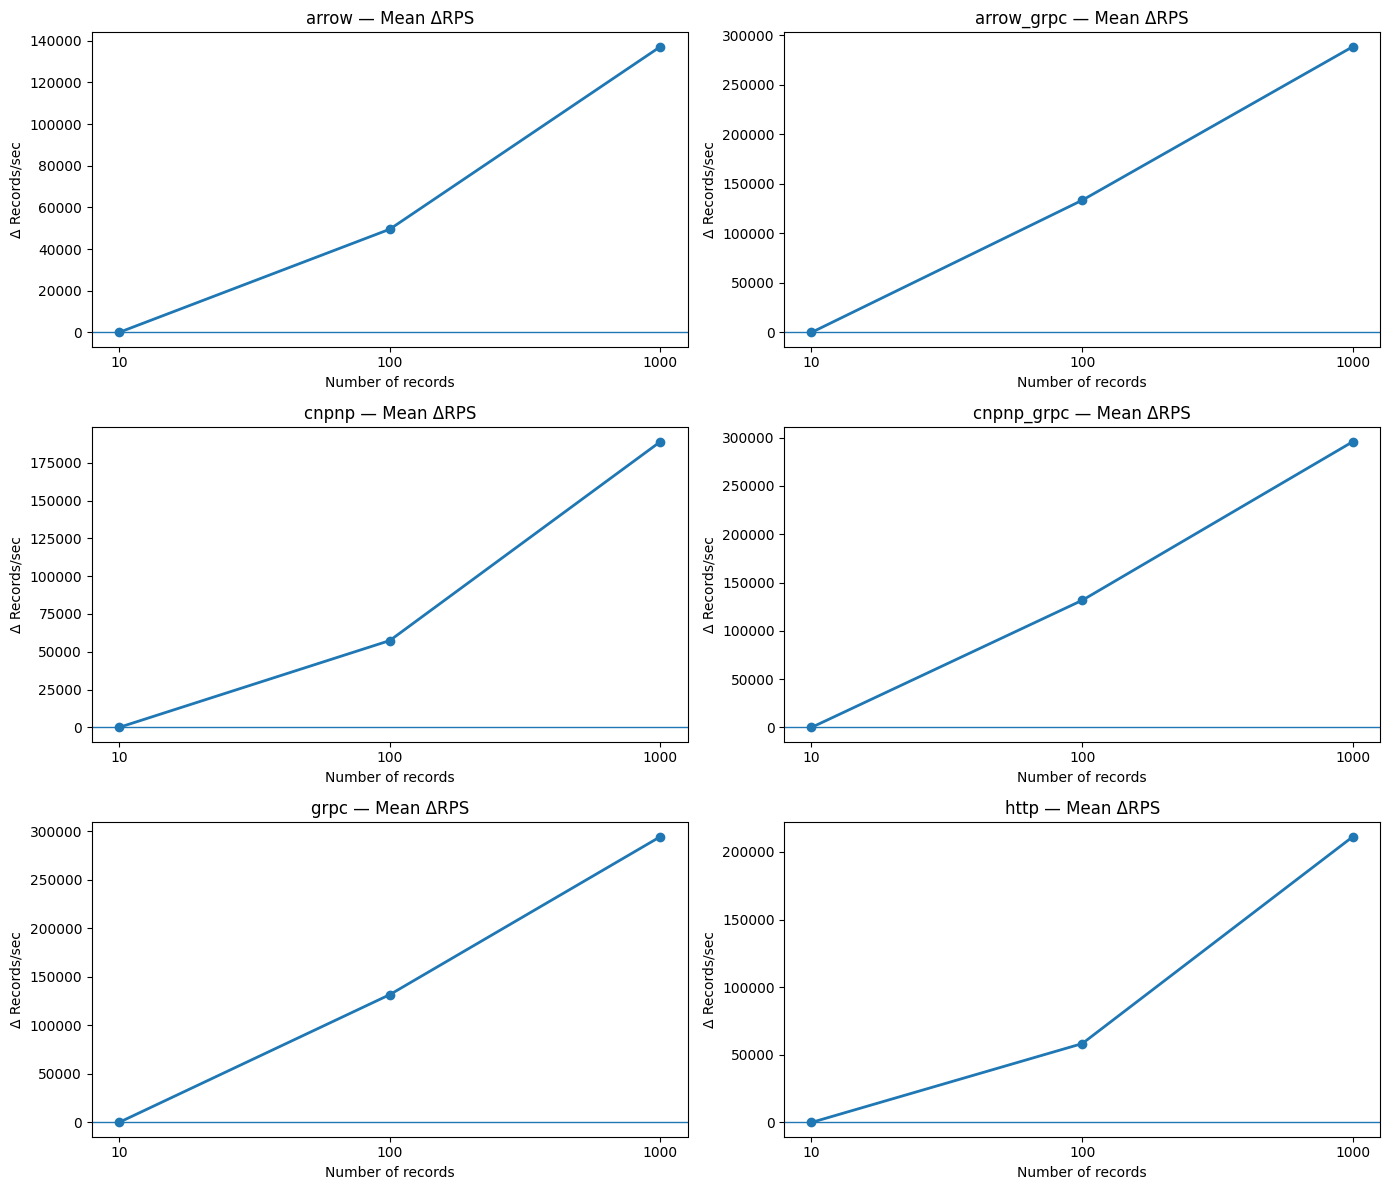

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Unique values
records_unique = sorted(grouped["records"].unique().to_list())
transports_unique = sorted(grouped["Transport"].unique().to_list())

# Layout
n_transports = len(transports_unique)
cols = 2
rows = (n_transports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), squeeze=False)
axes_flat = axes.flatten()

x = np.arange(len(records_unique))

for ax, transport in zip(axes_flat, transports_unique):
    df_t = (
        grouped
        .filter(pl.col("Transport") == transport)
        .sort("records")
    )

    values = df_t["rps_mean"].to_numpy()
    delta = np.diff(values, prepend=values[0])

    ax.plot(x, delta, marker="o", linewidth=2)
    ax.axhline(0, linewidth=1)

    ax.set_title(f"{transport} — Mean ΔRPS")
    ax.set_ylabel("Δ Records/sec")
    ax.set_xticks(x)
    ax.set_xticklabels([str(r) for r in records_unique])
    ax.set_xlabel("Number of records")

# Hide unused axes
for ax in axes_flat[len(transports_unique):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


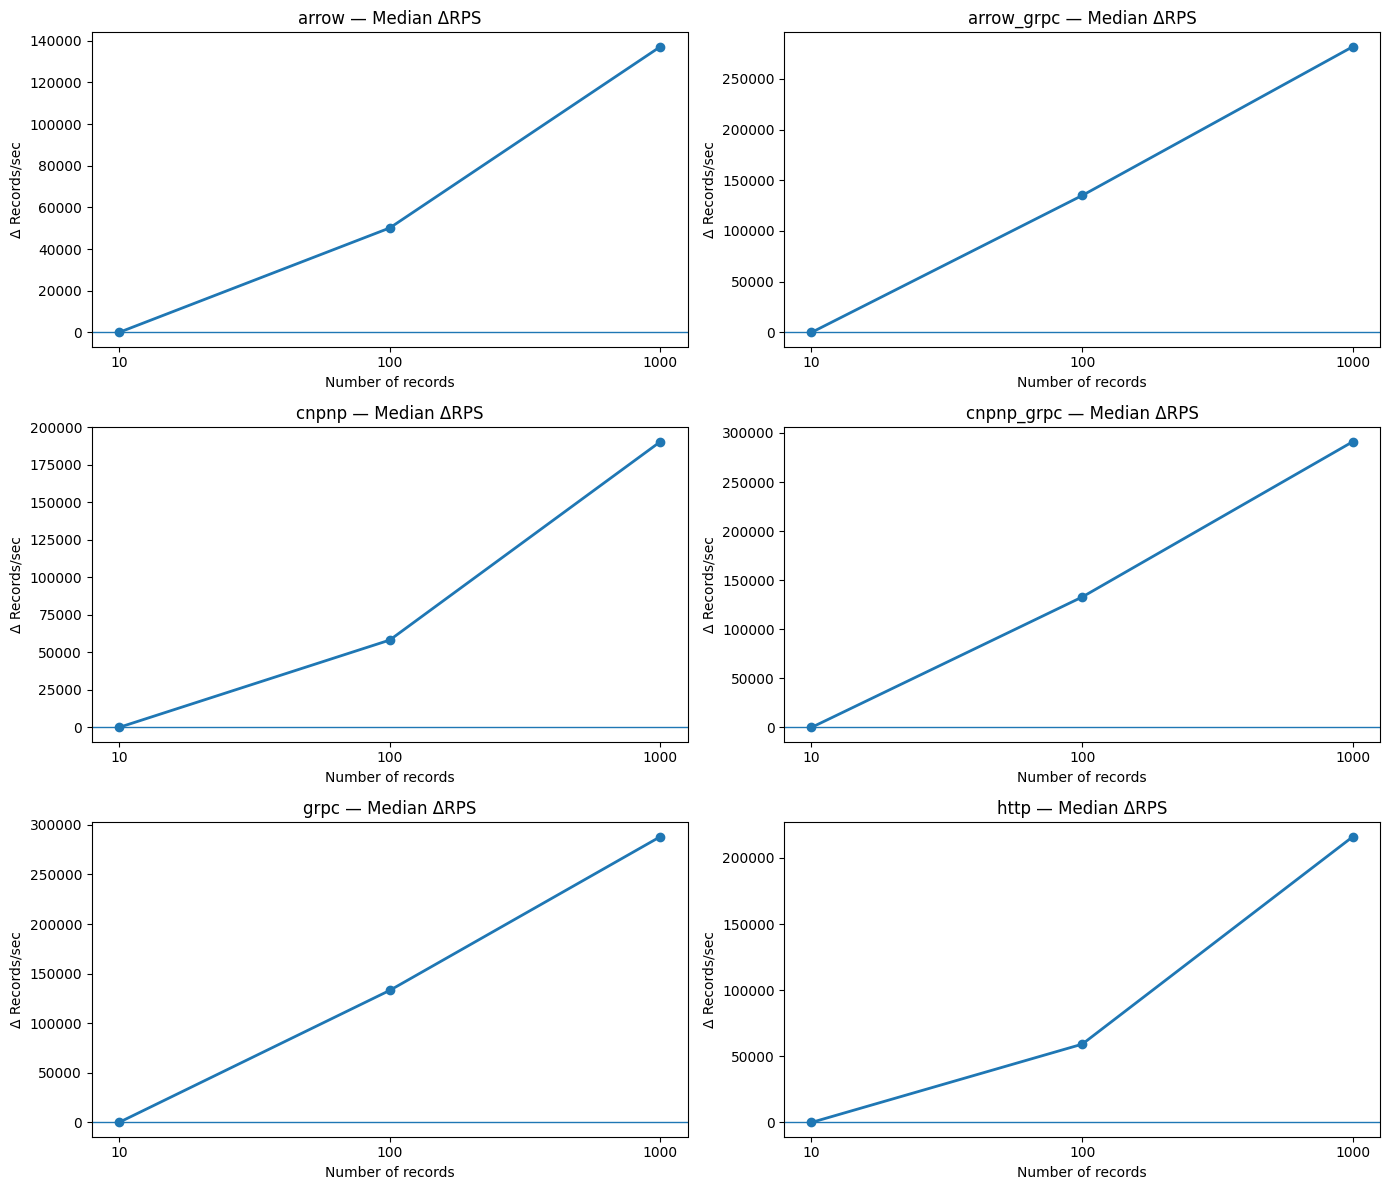

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Unique values
records_unique = sorted(grouped["records"].unique().to_list())
transports_unique = sorted(grouped["Transport"].unique().to_list())

# Layout
n_transports = len(transports_unique)
cols = 2
rows = (n_transports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), squeeze=False)
axes_flat = axes.flatten()

x = np.arange(len(records_unique))

for ax, transport in zip(axes_flat, transports_unique):
    df_t = (
        grouped
        .filter(pl.col("Transport") == transport)
        .sort("records")
    )

    values = df_t["rps_median"].to_numpy()
    delta = np.diff(values, prepend=values[0])

    ax.plot(x, delta, marker="o", linewidth=2)
    ax.axhline(0, linewidth=1)

    ax.set_title(f"{transport} — Median ΔRPS")
    ax.set_ylabel("Δ Records/sec")
    ax.set_xticks(x)
    ax.set_xticklabels([str(r) for r in records_unique])
    ax.set_xlabel("Number of records")

# Hide unused axes
for ax in axes_flat[len(transports_unique):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
